# Importing the libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/credit-card-fraud-detection-dataset-2023/creditcard_2023.csv


In [2]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score
import pickle
#-------------------------------------------------------------------------------------------------------------------------------
pd.set_option('display.max_columns', None )
import warnings                                                     
warnings.filterwarnings("ignore")

# Data Acquisition & Description

In [3]:
data = pd.read_csv('/kaggle/input/credit-card-fraud-detection-dataset-2023/creditcard_2023.csv')

In [4]:
all(data.index == data.id)

True

This means we can set the column `id` as index

In [5]:
data.set_index('id', inplace = True)

In [6]:
print('Shape of our dataset: ', data.shape)
data.sample(3)

Shape of our dataset:  (568630, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
559498,-0.467414,0.498175,-0.451626,0.658222,-0.230112,-0.068822,-0.527549,0.031108,-0.899034,-0.848349,0.954754,-1.039261,-0.571399,-1.124204,-0.122791,-1.201384,-1.110145,-1.026747,1.142032,0.420934,0.451878,-0.109269,-0.324640,-0.938500,0.244456,0.039822,1.048286,1.016217,2659.30,1
415015,-0.451260,-0.205222,0.912350,0.276228,0.395676,0.564528,1.109222,-0.596762,0.600926,2.240448,-0.326631,0.365916,0.074059,0.265012,1.648094,0.042545,0.493314,-0.126161,0.156796,-1.071171,0.070377,0.160343,0.138968,1.266447,-0.800508,-0.183435,-2.117913,0.548547,5517.52,1
225059,-0.128078,-0.521367,1.013348,-1.124551,0.733165,0.377118,0.880955,-0.182072,0.471894,0.307316,-0.233558,1.319198,-0.045270,0.693724,-1.286981,0.219448,0.293588,0.283872,0.165533,0.198128,-0.099106,-0.091183,0.087006,1.534981,0.058623,-0.391357,-0.390401,-0.307086,16535.56,0


In [7]:
#Lets see Data Information
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568630 entries, 0 to 568629
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      568630 non-null  float64
 1   V2      568630 non-null  float64
 2   V3      568630 non-null  float64
 3   V4      568630 non-null  float64
 4   V5      568630 non-null  float64
 5   V6      568630 non-null  float64
 6   V7      568630 non-null  float64
 7   V8      568630 non-null  float64
 8   V9      568630 non-null  float64
 9   V10     568630 non-null  float64
 10  V11     568630 non-null  float64
 11  V12     568630 non-null  float64
 12  V13     568630 non-null  float64
 13  V14     568630 non-null  float64
 14  V15     568630 non-null  float64
 15  V16     568630 non-null  float64
 16  V17     568630 non-null  float64
 17  V18     568630 non-null  float64
 18  V19     568630 non-null  float64
 19  V20     568630 non-null  float64
 20  V21     568630 non-null  float64
 21  V22     568630 

In [8]:
#Lets see data description
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,568630.0
mean,-5.638058e-17,-1.319545e-16,-3.518788e-17,-2.879008e-17,7.997245e-18,-3.958636e-17,-3.198898e-17,2.109273e-17,3.998623e-17,1.991314e-16,-1.183592e-16,-5.758017e-17,-5.698037e-18,-4.078595e-17,2.649087e-17,-1.719408e-17,-3.398829e-17,-5.837989e-17,2.479146e-17,-1.579456e-17,4.758361e-17,3.948640e-18,6.194741e-18,-2.799036e-18,-3.178905e-17,-7.497417e-18,-3.598760e-17,2.609101e-17,12041.957635,0.5
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,6919.644449,0.5
min,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222e+00,-9.952786e+00,-2.111111e+01,-4.351839e+00,-1.075634e+01,-3.751919e+00,-3.163276e+00,-5.954723e+00,-2.020399e+00,-5.955227e+00,-2.107417e+00,-3.861813e+00,-2.214513e+00,-2.484938e+00,-2.421949e+00,-7.804988e+00,-7.814784e+01,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969e+00,-1.049863e+01,-3.903524e+01,50.010000,0.0
25%,-5.652859e-01,-4.866777e-01,-6.492987e-01,-6.560203e-01,-2.934955e-01,-4.458712e-01,-2.835329e-01,-1.922572e-01,-5.687446e-01,-5.901008e-01,-7.014495e-01,-8.311331e-01,-6.966667e-01,-8.732057e-01,-6.212485e-01,-7.162655e-01,-6.194913e-01,-5.560458e-01,-5.653082e-01,-3.502399e-01,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-6.318948e-01,-3.049607e-01,-2.318783e-01,6054.892500,0.0
50%,-9.363846e-02,-1.358939e-01,3.528579e-04,-7.376152e-02,8.108788e-02,7.871758e-02,2.333659e-01,-1.145242e-01,9.252647e-02,2.626145e-01,-4.104986e-02,1.620521e-01,1.760812e-02,2.305011e-01,-3.925566e-02,1.340262e-01,2.716407e-01,8.729382e-02,-2.597869e-02,-1.233776e-01,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-1.189208e-02,-1.729111e-01,-1.392973e-02,12030.150000,0.5
75%,8.326582e-01,3.435552e-01,6.285380e-01,7.070047e-01,4.397368e-01,4.977881e-01,5.259548e-01,4.729905e-02,5.592621e-01,5.924603e-01,7.477730e-01,7.446723e-01,6.856048e-01,7.518216e-01,6.654065e-01,6.556061e-01,5.182242e-01,5.443887e-01,5.601164e-01,2.482164e-01,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,6.728879e-01,3.340230e-01,4.095903e-01,18036.330000,1.0
max,2.229046e+00,4.361865e+00,1.412583e+01,3.201536e+00,4.271689e+01,2.616840e+01,2.178730e+02,5.958040e+00,2.027006e+01,3.172271e+01,2.513573e+00,1.791356e+01,7.187486e+00,1.916954e+01,1.453220e+01,4.665291e+01,6.994124e+00,6.783716e+00,3.831672e+00,2.987281e+01,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285e+00,1.132311e+02,7.725594e+01,24039.930000,1.0


In [9]:
data['Class'].value_counts()

Class
0    284315
1    284315
Name: count, dtype: int64

**Observations**-
- We have 568630 Rows of observations having 30 columns.
- ``Class`` is our Output feature indicating whether the transaction is **fraudulent (1) or not (0).**
- We have balanced dataset

# Data Preprocessing

In [10]:
#Lets check for missing values
data.isna().sum().sum()

0

In [11]:
# Lets check for duplicates if any
data.duplicated().any()

True

In [12]:
## Dropping the duplicated values
data.drop_duplicates(keep = 'first', inplace = True)
data.duplicated().any()

False

**Observations**
- No missing values.
- No duplicates.
- dtype also looks fine.

### Exploratory Data Analysis

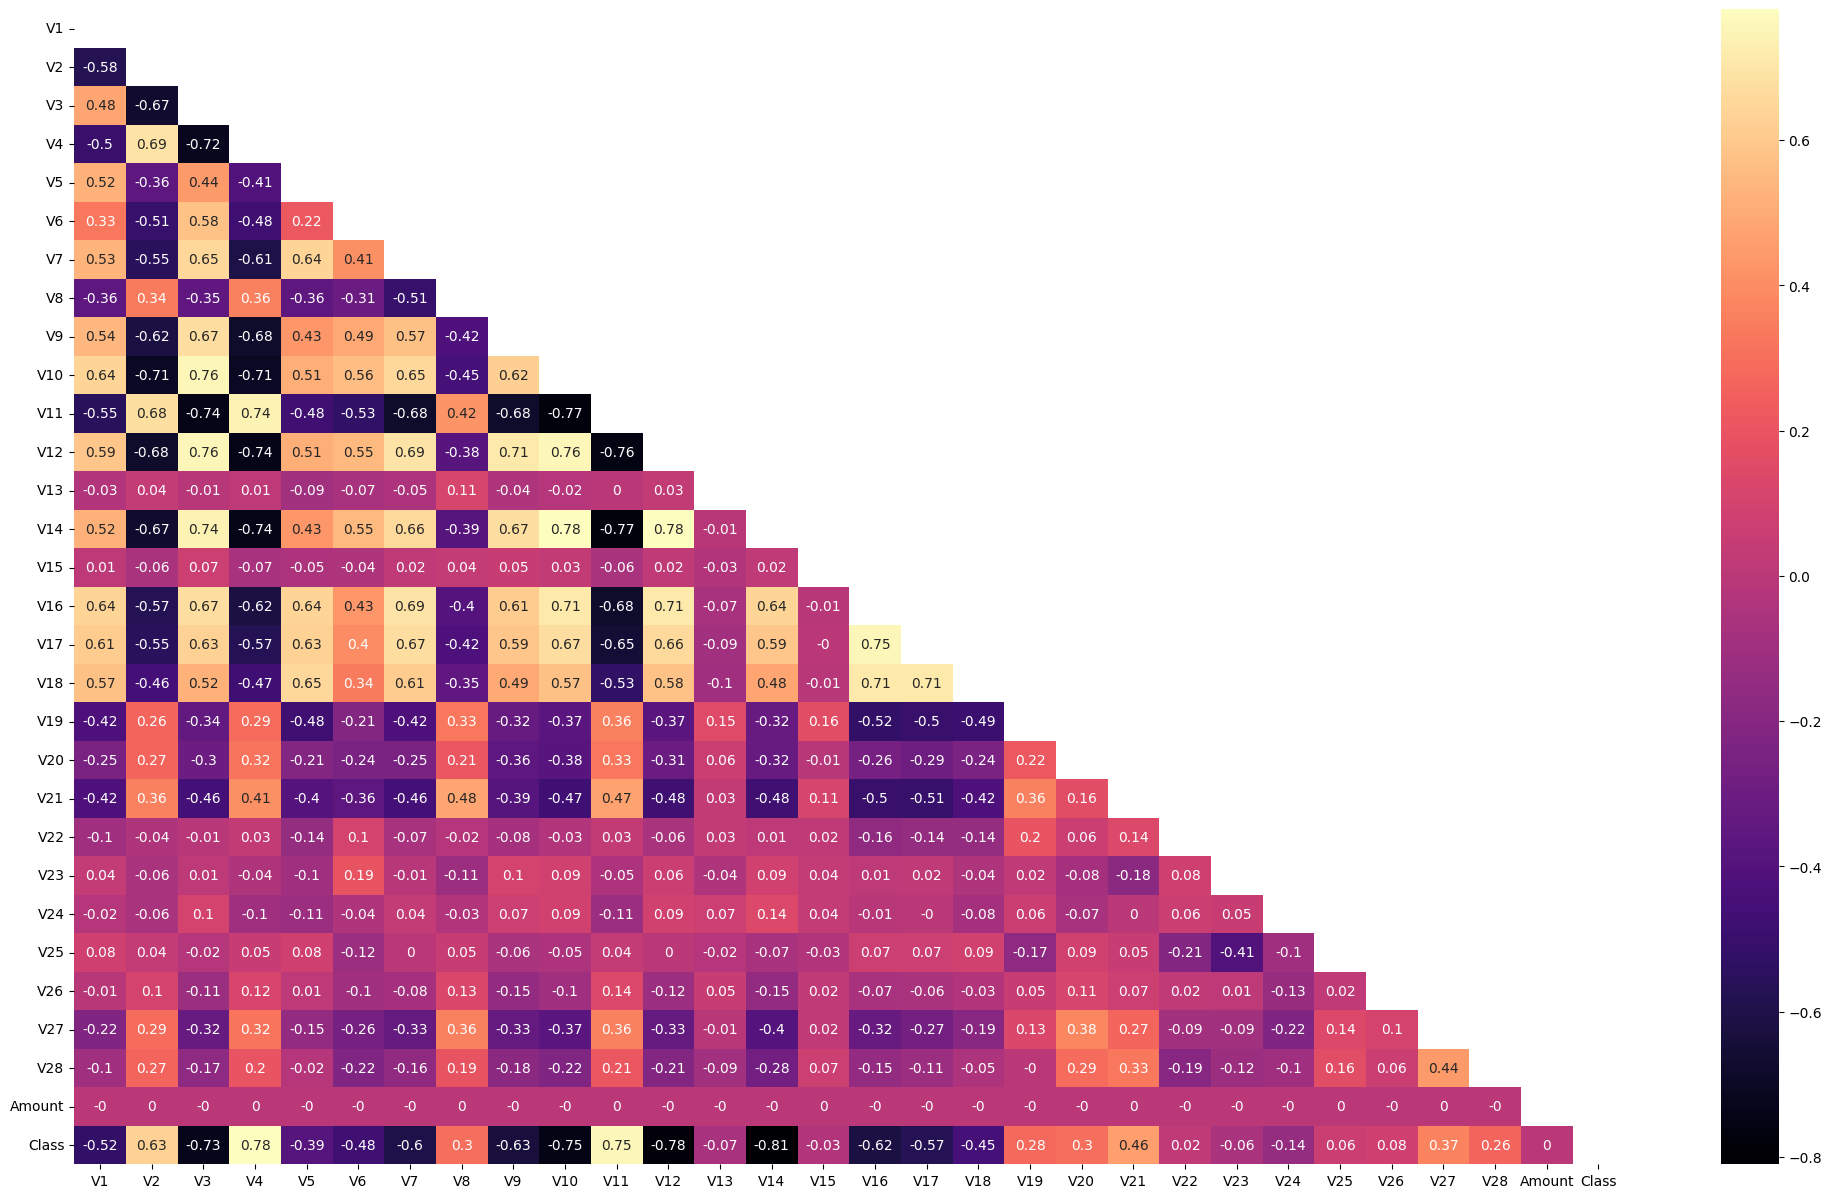

In [13]:
corr_df = data.corr(method = 'spearman').round(2)
mask = np.triu(np.ones_like(corr_df, dtype=bool))
plt.figure(figsize=[25,15])
sns.heatmap(corr_df, cmap=sns.color_palette("magma", as_cmap = True), annot=True, mask = mask)
plt.show()

Observations

* Few features have high co-relation among different features.
* V17 and V18 are higly co-related.
* V16 and V17 are higly co-related.
* V14 has a negative corelation with V4.
* V12 is also negatively co-related with V10 and V11.
* V11 is ngetively co-related with V10 and positvely with V4.
* V3 is positevely co-related with V10 and V12.
* V9 and V10 are also positively co-related.

In [14]:
def generate_corr_mat(df, high = 0.6, low = 0.1):
    """
        Filter the parameters based on their correlations' magnitude
    """
    corr_mat = {'highly_corr': dict(), 'low_corr': dict()}
    df = df.abs()
    cols = df.columns.tolist()
    for i, val in df.iterrows():
        corr_mat['highly_corr'][i] = [col for col in cols if val[col] > high and col != i]
        corr_mat['low_corr'][i] = [col for col in cols if val[col] < low]
        print(f"Parameters having high co-relation with parameter \033[1m{i}\033[0m is/are: ", corr_mat['highly_corr'][i])
        print(f"Parameters having apprx no co-relation with parameter \033[1m{i}\033[0m is/are: ", corr_mat['low_corr'][i])
        print()
    return corr_mat

correlation_matrix = generate_corr_mat(corr_df)

Parameters having high co-relation with parameter V1 is/are:  ['V10', 'V16', 'V17']
Parameters having apprx no co-relation with parameter V1 is/are:  ['V13', 'V15', 'V23', 'V24', 'V25', 'V26', 'Amount']

Parameters having high co-relation with parameter V2 is/are:  ['V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'Class']
Parameters having apprx no co-relation with parameter V2 is/are:  ['V13', 'V15', 'V22', 'V23', 'V24', 'V25', 'Amount']

Parameters having high co-relation with parameter V3 is/are:  ['V2', 'V4', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'Class']
Parameters having apprx no co-relation with parameter V3 is/are:  ['V13', 'V15', 'V22', 'V23', 'V25', 'Amount']

Parameters having high co-relation with parameter V4 is/are:  ['V2', 'V3', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'Class']
Parameters having apprx no co-relation with parameter V4 is/are:  ['V13', 'V15', 'V22', 'V23', 'V25', 'Amount']

Parameters having high co-relation with parameter V5 is/are:  [

### Lets check the skewness

skew() function in pandas:

The DataFrame class of pandas has a method skew() that computes the skewness of the data present in a given axis of the DataFrame object.

Important Notes:
- If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
- If the skewness is between -1 and -0.5 or between 0.5 and 1, the data are moderately skewed
- If the skewness is less than -1 or greater than 1, the data are highly skewed

In [15]:
data.skew().sort_values()

V20       -1.556427
V2        -1.397993
V6        -0.201658
V21       -0.109890
V23       -0.100113
V1        -0.083418
V4        -0.044166
V11       -0.020887
V26       -0.018960
V19       -0.010172
Class      0.000004
Amount     0.001657
V15        0.011231
V3         0.014619
V13        0.014908
V25        0.023010
V24        0.066086
V12        0.066756
V18        0.129188
V9         0.171059
V14        0.207832
V16        0.266405
V8         0.300354
V22        0.319002
V17        0.373058
V10        0.740411
V5         1.506412
V28        1.724991
V27        2.755469
V7        19.027130
dtype: float64

**Observations**
- Features like V20, V2 are highly `-vely` skewed.
- Features like V5, V28, V27 and V7 are highly `+vely` skewed.

#### Skewed Parameters

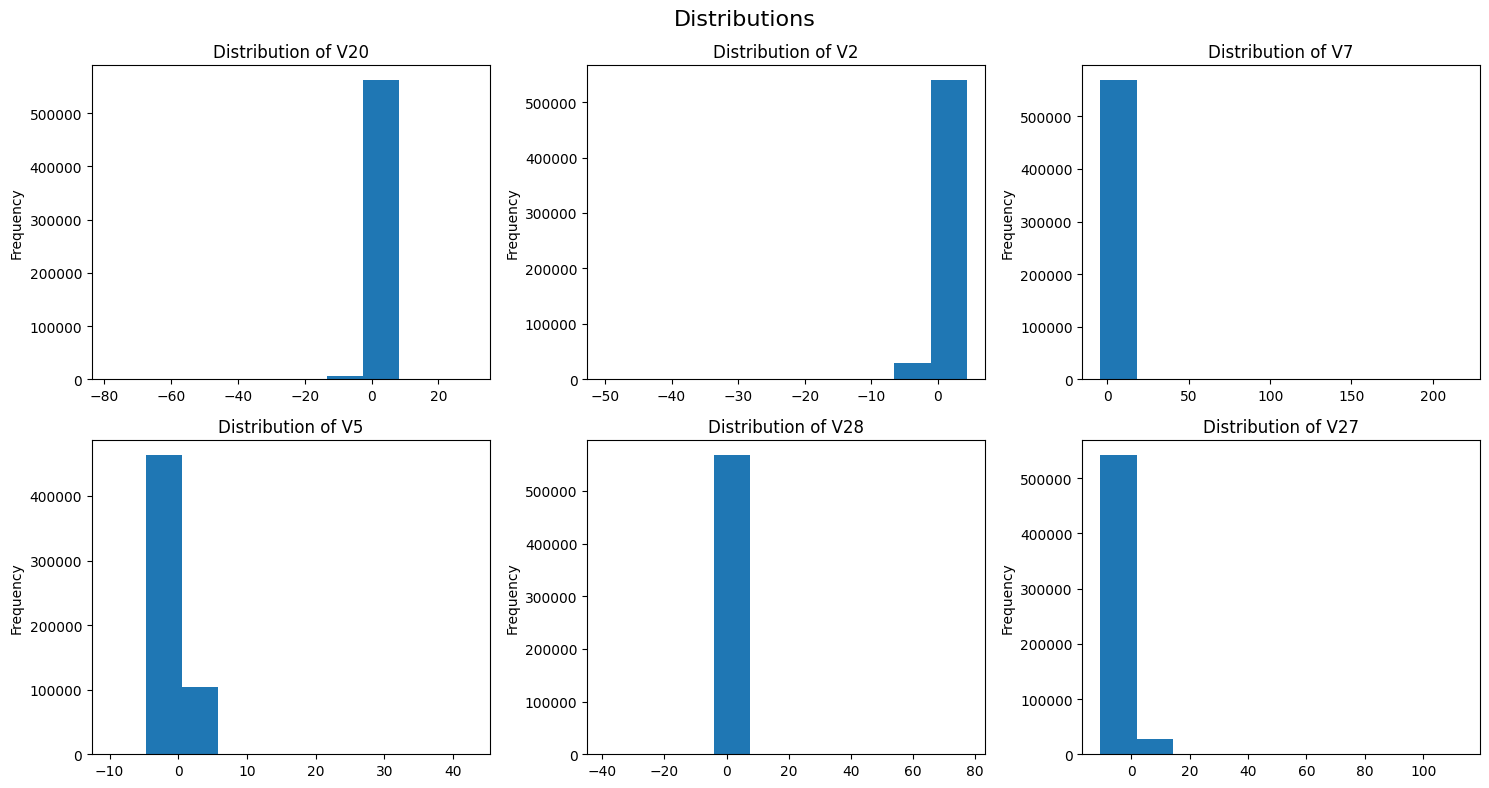

In [16]:
# Lets plot a histogram
paper, axes = plt.subplots(2, 3, figsize=(15, 8))
data['V20'].plot(kind='hist', ax=axes[0,0], title='Distribution of V20')
data['V2'].plot(kind='hist', ax=axes[0,1], title='Distribution of V2')
data['V7'].plot(kind='hist', ax=axes[0,2], title='Distribution of V7')
data['V5'].plot(kind='hist', ax=axes[1,0], title='Distribution of V5')
data['V28'].plot(kind='hist', ax=axes[1,1], title='Distribution of V28')
data['V27'].plot(kind='hist', ax=axes[1,2], title='Distribution of V27')
plt.suptitle('Distributions',size=16)
plt.tight_layout()
plt.show()

### Distribution of 'Amount' feature

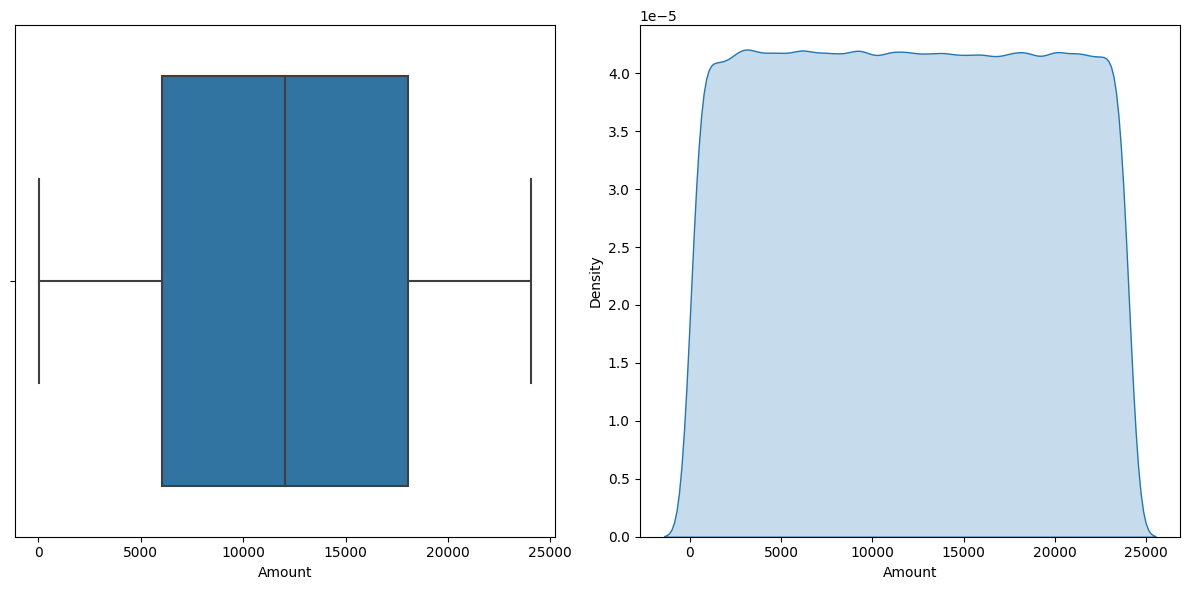

In [17]:
fig, axes = plt.subplots(1, 2, figsize = [12, 6])
sns.boxplot(data = data, x = 'Amount', ax = axes[0])
sns.kdeplot(data = data['Amount'], shade=True, ax = axes[1])
plt.tight_layout()
plt.show()

**Observations**:
- Amount is fairly Normally distributed, almost ideal in this case,

#### Lets look at our Output feature

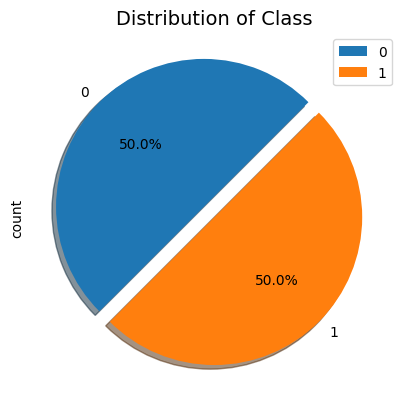

In [18]:
data['Class'].value_counts().plot.pie(explode=[0.1,0],autopct='%3.1f%%'
                                     ,shadow=True, legend= True,startangle =45)
plt.title('Distribution of Class',size=14)
plt.show()

**Observations**
- Our output feature is equally balanced.

# Data Preparation

In [19]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,-0.987020,0.293438,-0.941386,0.549020,1.804879,0.215598,0.512307,0.333644,0.124270,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,0.140107,1.564246,0.574074,0.627719,0.706121,0.789188,0.403810,0.201799,-0.340687,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,-0.272985,0.659201,0.805173,0.616874,3.069025,-0.577514,0.886526,0.239442,-2.366079,0.361652,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,-0.752581,0.737483,0.592994,0.559535,-0.697664,-0.030669,0.242629,2.178616,-1.345060,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,-1.203171,1.029577,1.439310,0.241454,0.153008,0.224538,0.366466,0.291782,0.445317,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


### Dividation of dependent and independent features

In [20]:
x = data.drop(columns = ['Class'], axis=1)
y = data.Class

In [21]:
x.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,-0.987020,0.293438,-0.941386,0.549020,1.804879,0.215598,0.512307,0.333644,0.124270,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,0.140107,1.564246,0.574074,0.627719,0.706121,0.789188,0.403810,0.201799,-0.340687,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,-0.272985,0.659201,0.805173,0.616874,3.069025,-0.577514,0.886526,0.239442,-2.366079,0.361652,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,-0.752581,0.737483,0.592994,0.559535,-0.697664,-0.030669,0.242629,2.178616,-1.345060,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,-1.203171,1.029577,1.439310,0.241454,0.153008,0.224538,0.366466,0.291782,0.445317,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97


In [22]:
print('Shape of x',x.shape)
print('Shape of y',y.shape)

Shape of x (568629, 29)
Shape of y (568629,)


### Feature Scaling

In [23]:
sc = StandardScaler()

In [24]:
x_scaled = sc.fit_transform(x) 
# pickle.dumps(open("scaler.pkl", 'wb'), sc)
x_scaled_df = pd.DataFrame(x_scaled,columns=x.columns)
x_scaled_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.260651,-0.469646,2.496265,-0.083723,0.129680,0.732910,0.519012,-0.130021,0.727159,0.637733,-0.987018,0.293437,-0.941392,0.549018,1.804877,0.215596,0.512305,0.333642,0.124270,0.091196,-0.110544,0.217603,-0.134788,0.165957,0.126280,-0.434824,-0.081228,-0.151042,0.858451
1,0.985098,-0.356042,0.558054,-0.429653,0.277139,0.428614,0.406464,-0.133133,0.347452,0.529807,0.140109,1.564244,0.574072,0.627717,0.706120,0.789187,0.403808,0.201798,-0.340687,-0.233995,-0.194933,-0.605794,0.079483,-0.577397,0.190090,0.296502,-0.248050,-0.064508,-0.796368
2,-0.260275,-0.949385,1.728536,-0.457985,0.074060,1.419499,0.743510,-0.095590,-0.261296,0.690706,-0.272983,0.659199,0.805172,0.616873,3.069022,-0.577516,0.886524,0.239440,-2.366077,0.361650,-0.005006,0.702920,0.945089,-1.154668,-0.605563,-0.312895,-0.300256,-0.244715,-1.377010
3,-0.152155,-0.508957,1.746839,-1.090176,0.249484,1.143327,0.518266,-0.065143,-0.205697,0.575229,-0.752579,0.737481,0.592992,0.559533,-0.697664,-0.030671,0.242628,2.178614,-1.345059,-0.378236,-0.146921,-0.038225,-0.214044,-1.893133,1.003963,-0.515950,-0.165314,0.048428,-0.962118
4,-0.206823,-0.165276,1.527051,-0.448291,0.106123,0.530559,0.658848,-0.212677,1.049920,0.968044,-1.203169,1.029576,1.439310,0.241452,0.153007,0.224536,0.366465,0.291780,0.445316,0.247233,-0.106976,0.729742,-0.161660,0.312559,-0.414115,1.071124,0.023714,0.419122,0.323288


### PCA

To handle the multi-collinearity

In [25]:
pca = PCA(n_components = 12)
x_new = pd.DataFrame(pca.fit_transform(x_scaled), columns = ['Col_'+ str(i) for i in range(12)])
# pickle.dumps(open('pca.pkl', 'wb'), pca)
x_new.head(3)

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,Col_10,Col_11
0,2.190566,-0.164056,0.264064,0.911254,0.490687,-1.351699,-0.090821,-1.172382,-0.754168,-1.109465,0.230110,0.036962
1,2.085246,0.354942,0.168958,0.019548,0.123351,0.632817,-0.889341,0.289913,-0.301593,-0.336636,-0.659061,-0.279806
2,2.283194,-0.522541,-0.361737,0.380939,1.140980,-0.144974,-1.806656,0.295732,-1.555360,-1.249902,-1.791872,0.372121


### Data Split

In [26]:
x_train,x_test,y_train,y_test = train_test_split(x_new, y, test_size=0.25, random_state=15, stratify= y)
cv = StratifiedKFold(n_splits = 8, shuffle = True)

In [27]:
#Lets see the shapes
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(426471, 12)
(142158, 12)
(426471,)
(142158,)


# Modelling

In [28]:
def train_model(model, X_train, y_train, X_test, y_test):
    # Fit model
    model.fit(X_train, y_train)
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred)
    
    print('Accuracy: ', accuracy)
    print('F1 Score: ', f1)
    print('AUC(ROC): ', roc_auc)
    print()
    print("Classification Report: ")
    print(classification_report(y_test, y_pred))
    
    ## ROC AUC
    prob = model.predict_proba(X_test)  
    prob = prob[:, 1]
    fper, tper, _ = roc_curve(y_test, prob)
    auc_scr = auc(fper, tper)
    
    
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))
    axes[0].plot(fper, tper, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_scr)
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0].legend(loc="lower right")
    
    sns.heatmap(confusion_matrix(y_test, y_pred), ax = axes[1], annot = True, cbar = False)
    axes[1].set_xlabel('Predicted labels')
    axes[1].set_ylabel('Actual labels')
    
    plt.show()
    
    # Return evaluation metrics
    return model, accuracy, f1, roc_auc

### Logistic Regression

Accuracy:  0.9538119557112509
F1 Score:  0.9537824807720385
AUC(ROC):  0.9538119557112509

Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     71079
           1       0.98      0.93      0.95     71079

    accuracy                           0.95    142158
   macro avg       0.95      0.95      0.95    142158
weighted avg       0.95      0.95      0.95    142158



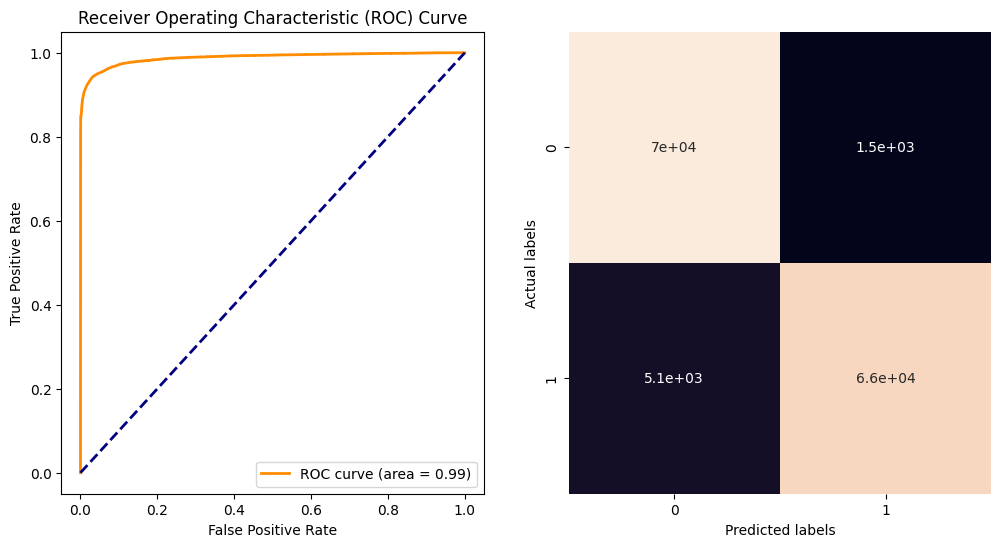

In [29]:
model_lr = LogisticRegression()
time_start = time.time()
model_lr, acc_lr, f1_lr, roc_auc_lr = train_model(model_lr, x_train, y_train, x_test, y_test)
time_taken_lr = time.time() - time_start

### GaussianNB

Accuracy:  0.9355224468549079
F1 Score:  0.9354309957317735
AUC(ROC):  0.9355224468549079

Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     71079
           1       0.97      0.90      0.93     71079

    accuracy                           0.94    142158
   macro avg       0.94      0.94      0.94    142158
weighted avg       0.94      0.94      0.94    142158



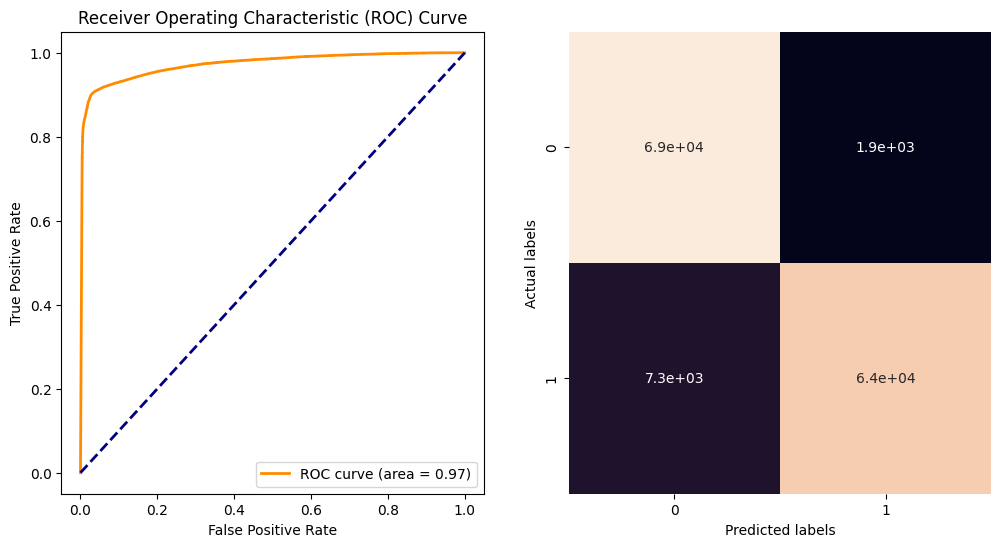

In [30]:
model_gnb = GaussianNB()
time_start = time.time()
model_gnb, acc_gnb, f1_gnb, roc_auc_gnb = train_model(model_gnb, x_train, y_train, x_test, y_test)
time_taken_gnb = time.time() - time_start

###  Decision Tree

Accuracy:  0.9954416916388806
F1 Score:  0.9954416854233552
AUC(ROC):  0.9954416916388809

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71079
           1       0.99      1.00      1.00     71079

    accuracy                           1.00    142158
   macro avg       1.00      1.00      1.00    142158
weighted avg       1.00      1.00      1.00    142158



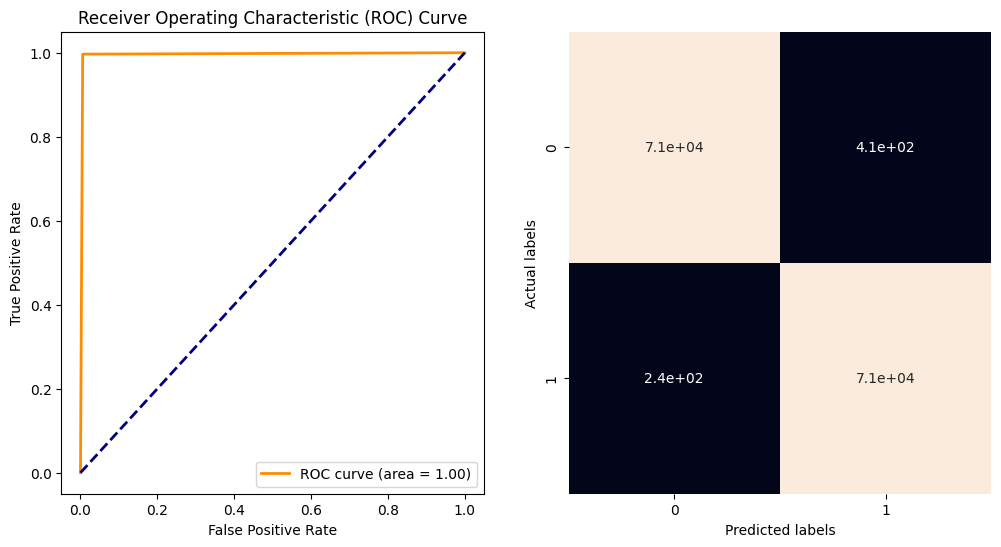

In [31]:
model_dt = DecisionTreeClassifier()
time_start = time.time()
model_dt, acc_dt, f1_dt, roc_auc_dt = train_model(model_dt, x_train, y_train, x_test, y_test)
time_taken_dt = time.time() - time_start

### Random Forest

Accuracy:  0.9994231770283769
F1 Score:  0.9994231770169596
AUC(ROC):  0.9994231770283769

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       1.00      1.00      1.00     71079

    accuracy                           1.00    142158
   macro avg       1.00      1.00      1.00    142158
weighted avg       1.00      1.00      1.00    142158



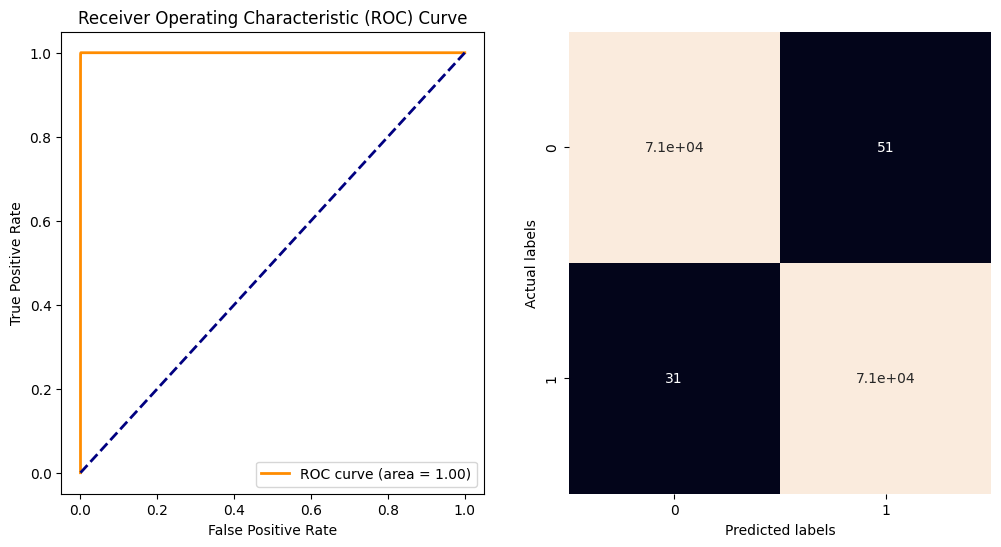

In [32]:
model_rf = RandomForestClassifier()
time_start = time.time()
model_rf, acc_rf, f1_rf, roc_auc_rf = train_model(model_rf, x_train, y_train, x_test, y_test)
time_taken_rf = time.time() - time_start

### XGBoost

Accuracy:  0.962239198638135
F1 Score:  0.9622094281026757
AUC(ROC):  0.9622391986381351

Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     71079
           1       0.99      0.93      0.96     71079

    accuracy                           0.96    142158
   macro avg       0.96      0.96      0.96    142158
weighted avg       0.96      0.96      0.96    142158



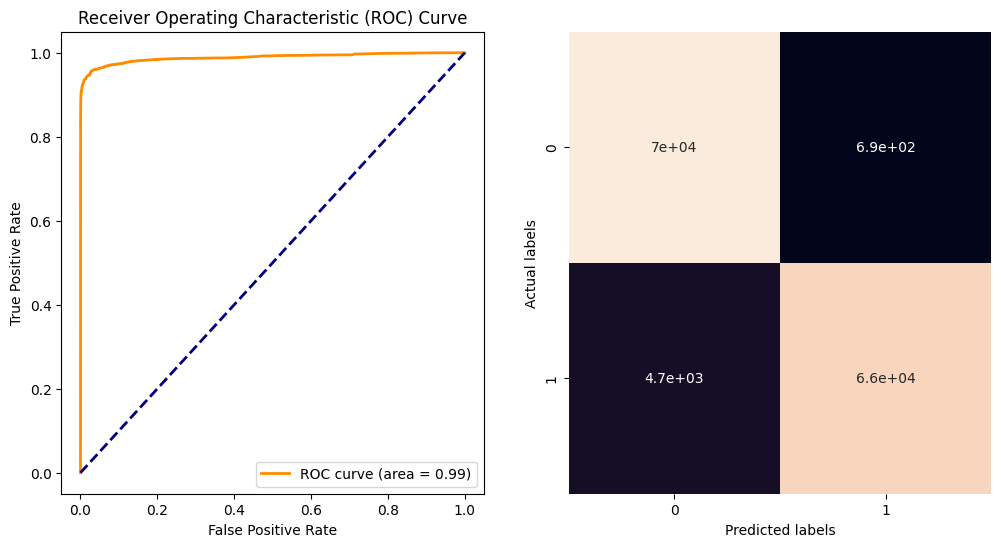

In [33]:
model_xgb = xgb.XGBRFClassifier()
time_start = time.time()
model_xgb, acc_xgb, f1_xgb, roc_auc_xgb = train_model(model_xgb, x_train, y_train, x_test, y_test)
time_taken_xgb = time.time() - time_start

In [34]:
accuracies = [acc_lr, acc_gnb, acc_dt, acc_rf, acc_xgb]
f_score = [f1_lr, f1_gnb, f1_dt, f1_rf, f1_xgb]
roc_auc = [roc_auc_lr, roc_auc_gnb, roc_auc_dt, roc_auc_rf, roc_auc_xgb]
time = [time_taken_lr, time_taken_gnb, time_taken_dt, time_taken_rf, time_taken_xgb]

final_df = pd.DataFrame({"Accuracies": accuracies, "F1 Scores": f_score, "ROC AUC": roc_auc, "Time Taken": time}, 
                       index = ['LogisticReg', 'GaussianNB', 'DecisionTree', 'RandomForest', 'XGB'])
final_df = final_df.round(4)
final_df

,Accuracies,F1 Scores,ROC AUC,Time Taken
LogisticReg,0.9538,0.9538,0.9538,2.0527
GaussianNB,0.9355,0.9354,0.9355,1.0889
DecisionTree,0.9954,0.9954,0.9954,21.3026
RandomForest,0.9994,0.9994,0.9994,292.0923
XGB,0.9622,0.9622,0.9622,4.8818


# Hyperparameter Tuning (for XGBoost)

In [58]:
from sklearn.model_selection import RandomizedSearchCV
param_dist_xgb = {
    'n_estimators': [50,100,150,200,300,400],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6]
}
xgb_clf = RandomizedSearchCV(model_xgb,param_dist_xgb,verbose = 2)
xgb_clf.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=300; total time=   6.5s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=300; total time=   7.7s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=300; total time=   6.5s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=300; total time=   6.5s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=300; total time=   6.3s
[CV] END ....learning_rate=0.3, max_depth=3, n_estimators=50; total time=   1.5s
[CV] END ....learning_rate=0.3, max_depth=3, n_estimators=50; total time=   1.5s
[CV] END ....learning_rate=0.3, max_depth=3, n_estimators=50; total time=   1.5s
[CV] END ....learning_rate=0.3, max_depth=3, n_estimators=50; total time=   1.5s
[CV] END ....learning_rate=0.3, max_depth=3, n_estimators=50; total time=   1.5s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=150; total time=   5.8s
[CV] END ...learning_rate=0.1, max_depth=6, n_es

RandomizedSearchCV(estimator=XGBRFClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamma=None,
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             max_bin=None,
                                             max_cat_threshold=None,
                                             ma...
                                             max_depth=None, max_leaves=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             multi_strategy=None,
                                             n_estimators=None, n_jobs=None,
                                             num_parallel_tree=None,
                                             objective='binary:logistic',
                                             random_state=None, reg_alpha=None, ...),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [50, 100, 150, 200, 300,
                                                         400]},
                   verbose=2)

In [59]:
#Best Hyper paramters for XG Boost
print('Best Parameters for XG Boost :',xgb_clf.best_params_)

Best Parameters for XG Boost : {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.1}


In [60]:
preds_xgb_clf_train = xgb_clf.predict(x_train)
preds_xgb_clf_test = xgb_clf.predict(x_test)

In [63]:
def model_eval(actual, predicted):
  acc_score = accuracy_score(actual, predicted)
  conf_matrix = confusion_matrix(actual, predicted)
  clas_rep = classification_report(actual, predicted)
  print('Model Accuracy is: ', round(acc_score, 2))
  print(conf_matrix)
  print(clas_rep)

In [64]:
print('-------Training Accuracy---------')
model_eval(y_train,preds_xgb_clf_train)

-------Training Accuracy---------
Model Accuracy is:  0.96
[[211223   2013]
 [ 13804 199431]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96    213236
           1       0.99      0.94      0.96    213235

    accuracy                           0.96    426471
   macro avg       0.96      0.96      0.96    426471
weighted avg       0.96      0.96      0.96    426471



In [65]:
print('-------Test Accuracy---------')
model_eval(y_test,preds_xgb_clf_test)

-------Test Accuracy---------
Model Accuracy is:  0.96
[[70401   678]
 [ 4674 66405]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     71079
           1       0.99      0.93      0.96     71079

    accuracy                           0.96    142158
   macro avg       0.96      0.96      0.96    142158
weighted avg       0.96      0.96      0.96    142158



# Conclusion

 We have  done Exploratory Data analysis for different features.
- We prepared our Data and build different ML Models.
- We have seen how different models are performing w.r.t Accuracy, Precision, Recall, F1 Scores and AUC ROC.
- Decision Tree with default parameters is giving **99.56%** accuracy on test dataset [computational inexpensive].
- Random Forest with default parameters is giving **99.94%** accuracy on test dataset [computational expensive].